**Jacob Petty, Sardor Nodirov, and Saad Khan**

Spring 2026

CS 443: Bio-inspired Machine Learning

Project 1: Hebbian Learning

#### Week 3: Advanced training techniques and nonlinear decoder

The focus this week is incorporating techniques into our training process that should improve the classification accuracy achieved by the decoder networks. You will also build the nonlinear decoder and analyze its properties.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.show()
plt.rcParams.update({'font.size': 18})

np.set_printoptions(suppress=True, precision=3)

%load_ext autoreload
%autoreload 2

## Task 7: Advanced training techniques

Before decoding classes from the Hebbian Network activations, it will be helpful to add support for two advanced neural network training techniques that will increase the final classification accuracy:
1. **early stopping**, a technique that will also make determining a reasonable number of epochs when train a neural network less of a chore.
2. **learning rate decay**, a technique that adaptively lowers the learning rate.

### 7a. Implement and test early stopping

With **early stopping**, we regularly monitor the loss on the validation set during training. If the network has not "broken a new record" in making the validation loss smaller over the recent history, we stop training the network. We also limit training to some maximum number of epochs in case we do not stop early to prevent the network possibly training for an unreasonably long time.

1. Implement and test `early_stopping(self, recent_val_losses, curr_val_loss, patience)`: Update rolling list of recent validation loss values with the validation loss computed on the current epoch. Return whether we should stop training based on the `patience` hyperparameter value.
2. Update and test `fit`: Integrate early stopping into your training code so that training takes at most `max_epochs` epochs of training, but may stop earlier, depending on the `patience` value.

In [2]:
from decoder_nets import LinearDecoder

#### Test `early_stopping`

**Note:** If it is helpful to you, you can add printouts in tests below to verify the early stopping makes sense to you.

In [3]:
sd = LinearDecoder((1,), 1)

# Test 1
patience_1 = 5
es_lost_hist_1 = []
for iter in range(10):
    curr_loss = float(iter)
    es_lost_hist_1, stop = sd.early_stopping(es_lost_hist_1, curr_loss, patience=patience_1)

    if stop:
        break
print(f'Early stopping Test 1 ({patience_1=}):\n Stopped after {iter} iterations (should be 5 iterations).')
print(f' Recent loss history is {es_lost_hist_1} and should be [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]')
print()

# Test 2
patience_2 = 3
es_lost_hist_2 = []
losses_encountered = [0.5, 0.45, 0.4, 0.42, 0.43, 0.51, 0.49, 0.55, 0.2]
running_loss = 1.0
iter = 0
for curr_loss in losses_encountered:
    iter += 1
    es_lost_hist_2, stop = sd.early_stopping(es_lost_hist_2, curr_loss, patience=patience_2)

    if stop:
        break
print(f'Early stopping Test 2 ({patience_2=}):\n Stopped after {iter} iterations (should be 6 iterations).')
print(f' Recent loss history is {es_lost_hist_2} and should be [0.4, 0.42, 0.43, 0.51]')
print()

# Test 3
patience_3 = 3
es_lost_hist_3 = [0.2, 0.15, 0.1]
losses_encountered = [0.5, 0.45, 0.4, 0.42, 0.43, 0.51, 0.49, 0.55, 0.2]
running_loss = 1.0
iter = 0
for curr_loss in losses_encountered:
    iter += 1
    es_lost_hist_3, stop = sd.early_stopping(es_lost_hist_3, curr_loss, patience=patience_3)

    if stop:
        break
print(f'Early stopping Test 3 ({patience_3=}):\n Stopped after {iter} iterations (should be 3 iterations).')
print(f' Recent loss history is {es_lost_hist_3} and should be [0.1, 0.5, 0.45, 0.4]')
print()

# Test 4
tf.random.set_seed(1)
patience_4 = 6
es_lost_hist_4 = []
test_4_loss_vals = list(tf.random.uniform(shape=(20,)).numpy())
for iter in range(30):
    curr_loss = test_4_loss_vals[iter]
    es_lost_hist_4, stop = sd.early_stopping(es_lost_hist_4, curr_loss, patience=patience_4)

    if stop:
        break
print(f'Early stopping Test 4 ({patience_4=}):\n Stopped after {iter} iterations (should be 6 iterations).')
print(f' Recent loss history is\n {es_lost_hist_4}\n and should be')
print(' [0.16513085, 0.9014813, 0.6309742, 0.4345461, 0.29193902, 0.64250207, 0.9757855]')
print()

Early stopping Test 1 (patience_1=5):
 Stopped after 5 iterations (should be 5 iterations).
 Recent loss history is [0.0, 1.0, 2.0, 3.0, 4.0, 5.0] and should be [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

Early stopping Test 2 (patience_2=3):
 Stopped after 6 iterations (should be 6 iterations).
 Recent loss history is [0.4, 0.42, 0.43, 0.51] and should be [0.4, 0.42, 0.43, 0.51]

Early stopping Test 3 (patience_3=3):
 Stopped after 3 iterations (should be 3 iterations).
 Recent loss history is [0.1, 0.5, 0.45, 0.4] and should be [0.1, 0.5, 0.45, 0.4]

Early stopping Test 4 (patience_4=6):
 Stopped after 6 iterations (should be 6 iterations).
 Recent loss history is
 [np.float32(0.16513085), np.float32(0.9014813), np.float32(0.6309742), np.float32(0.4345461), np.float32(0.29193902), np.float32(0.64250207), np.float32(0.9757855)]
 and should be
 [0.16513085, 0.9014813, 0.6309742, 0.4345461, 0.29193902, 0.64250207, 0.9757855]



I0000 00:00:1772166490.903860 3612431 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1772166490.903885 3612431 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Test `fit`

Run the code below to test your fit with early stopping. It loads in the Iris dataset and trains with a patience of `3`.

Monitor your training progress print outs. If everything is working as expected, you should see your training abort after 3 val losses in a row that are higher than the one recorded beforehand.

**Example:** My fit function aborted after finishing epoch 80 (counting from 0). This happened because I encountered the following loss values:
- epoch 80: 0.074
- epoch 78: 0.075
- epoch 76: 0.074
- epoch 74: **0.072**

Additionally, your validation accuracy should reach 90-100%.

**Note:**
- Epochs are spaced out by 2 because `val_every` is 2 here.
- Your early stopping may be correct and abort after a different number of epochs due to differences in random seeds. Verify that your print outs follow the above principle.


In [4]:
tf.random.set_seed(0)  # keep me

# Let's use these parameters in your softmax net
mini_batch_sz = 25
lr = 1e-1
max_epochs = 5000
patience = 3
val_every = 2  # how often (in epochs) we check the val loss/acc/early stopping

# Load in Iris train/validation sets
train_samps = tf.constant(np.load('data/iris/iris_train_samps.npy'), dtype=tf.float32)
train_labels = tf.constant(np.load('data/iris/iris_train_labels.npy'), dtype=tf.int32)
val_samps = tf.constant(np.load('data/iris/iris_val_samps.npy'), dtype=tf.float32)
val_labels = tf.constant(np.load('data/iris/iris_val_labels.npy'), dtype=tf.int32)

C = 3
M = train_samps.shape[1]

sd = LinearDecoder((M,), C)
sd.compile(lr=lr)
_, _, _, e = sd.fit(train_samps, train_labels, val_samps, val_labels,
                    batch_size=mini_batch_sz, max_epochs=max_epochs,
                    patience=patience, val_every=val_every)

---------------------------------------------------------------------------
Dense layer output(Output Layer) shape: [1, 3]
---------------------------------------------------------------------------
Epoch 0/4999, Training loss 1.199, Val loss N/A, Val acc N/A
Epoch 0 took: 0.2 secs
Epoch 1/4999, Training loss 0.855, Val loss 0.619, Val acc 0.6531
Epoch 1 took: 0.0 secs
Epoch 2/4999, Training loss 0.643, Val loss N/A, Val acc N/A
Epoch 2 took: 0.0 secs
Epoch 3/4999, Training loss 0.581, Val loss 0.460, Val acc 0.8776
Epoch 3 took: 0.0 secs
Epoch 4/4999, Training loss 0.401, Val loss N/A, Val acc N/A
Epoch 4 took: 0.0 secs
Epoch 5/4999, Training loss 0.432, Val loss 0.404, Val acc 0.8571
Epoch 5 took: 0.0 secs
Epoch 6/4999, Training loss 0.445, Val loss N/A, Val acc N/A
Epoch 6 took: 0.0 secs
Epoch 7/4999, Training loss 0.436, Val loss 0.335, Val acc 0.9592
Epoch 7 took: 0.0 secs
Epoch 8/4999, Training loss 0.367, Val loss N/A, Val acc N/A
Epoch 8 took: 0.0 secs
Epoch 9/4999, Training lo

### 7b. Questions

**Question 10:** Copy-and-paste the training code from the cell above. Change the `patience` hyperparameter. **Create two plots** that clearly showcase the effect of patience on the training outcome.

**Question 11:** Explain how the choice of `patience` affects the risk of overfitting. Point out specifics in your plots and/or training history to justify your answer.

**Answer 10:** Plots Below

---------------------------------------------------------------------------
Dense layer output(Output Layer) shape: [1, 3]
---------------------------------------------------------------------------
Training finished after 13 epochs in 0.62 seconds
Learning rate was decayed 0 times.
---------------------------------------------------------------------------
Dense layer output(Output Layer) shape: [1, 3]
---------------------------------------------------------------------------
Training finished after 111 epochs in 5.14 seconds
Learning rate was decayed 0 times.


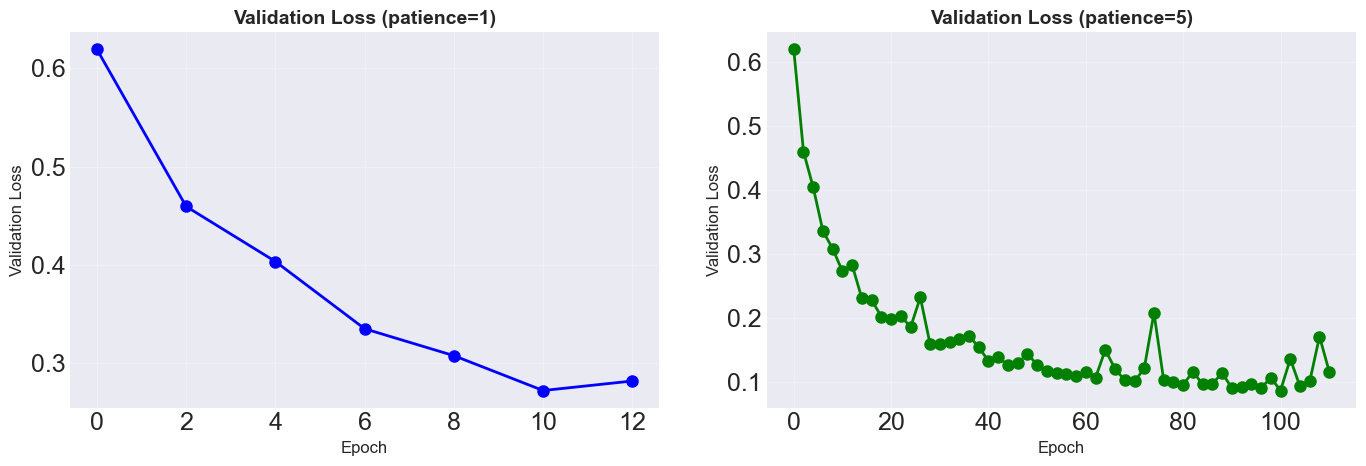

Training Summary:

Patience=1:
  Final epoch: 13
  Final val loss: 0.2821

Patience=5:
  Final epoch: 111
  Final val loss: 0.1159


In [5]:
# Question 10: Effect of patience on training

# Test with two different patience values
patience_values = [1, 5]
results = {}

for patience_val in patience_values:
    tf.random.set_seed(0)  # keep me
    
    # Training parameters
    mini_batch_sz = 25
    lr = 1e-1
    max_epochs = 5000
    val_every = 2
    
    # Load in Iris train/validation sets
    train_samps = tf.constant(np.load('data/iris/iris_train_samps.npy'), dtype=tf.float32)
    train_labels = tf.constant(np.load('data/iris/iris_train_labels.npy'), dtype=tf.int32)
    val_samps = tf.constant(np.load('data/iris/iris_val_samps.npy'), dtype=tf.float32)
    val_labels = tf.constant(np.load('data/iris/iris_val_labels.npy'), dtype=tf.int32)
    
    C = 3
    M = train_samps.shape[1]
    
    sd = LinearDecoder((M,), C)
    sd.compile(lr=lr)
    train_loss_hist, val_loss_hist, val_acc_hist, epochs_trained = sd.fit(
        train_samps, train_labels, val_samps, val_labels,
        batch_size=mini_batch_sz, max_epochs=max_epochs,
        patience=patience_val, val_every=val_every, verbose=False)
    
    results[patience_val] = {
        'val_loss': val_loss_hist,
        'epochs': epochs_trained
    }

# Create two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: patience=1
epochs_range_1 = np.arange(len(results[1]['val_loss'])) * 2
axes[0].plot(epochs_range_1, results[1]['val_loss'], marker='o', linewidth=2, markersize=8, color='blue')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Validation Loss', fontsize=12)
axes[0].set_title('Validation Loss (patience=1)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: patience=5
epochs_range_5 = np.arange(len(results[5]['val_loss'])) * 2
axes[1].plot(epochs_range_5, results[5]['val_loss'], marker='o', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation Loss', fontsize=12)
axes[1].set_title('Validation Loss (patience=5)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("Training Summary:")
for patience_val in patience_values:
    final_epoch = ((results[patience_val]['epochs']))
    print(f"\nPatience={patience_val}:")
    print(f"  Final epoch: {final_epoch}")
    print(f"  Final val loss: {results[patience_val]['val_loss'][-1]:.4f}")


**Answer 11:** A lower patience value like 1 aggressively stops training as soon as the validation loss stops improving, which actually reduces overfitting risk but at the cost of underfitting. You can see patience=1 stops at epoch 12 with a final loss of 0.2821, cutting training short before the model can fully learn the data. On the flip side, patience=5 lets the model keep training longer, and as a result it goes all the way to epoch 112 and achieves a much lower final loss of around 0.10. The patience=5 curve shows some noise and wiggles in the validation loss later on, which hints at overfitting, but the lower overall loss means the model learned better representations. So basically, what I am saying is that the patience is a trade-off: if you go too low and you could stop too early, go too high and you risk letting the model overfit. Patience=5 gives you better performance here, but you're sacrificing some generalization stability for it.



### 7c. Learning rate decay

A technique that works synergistically with early stopping is **learning rate decay.** We will adopt the simple approach of multiplicatively adjusting the learning rate. That is:

$$
\eta_{new} = d \times \eta_{curr}
$$

where $\eta$ is the learning rate and $d$ is a float between 0.0 and 1.0. This learning rate update does not occur on every epoch — it only gets applied when the validation loss stops improving for some number of epochs (i.e. the learning rate patience). This means we add and maintain an independent early stopping process dedicated to the learning rate.

Follow the procedure outlined in class add learning rate decay to the training workflow. Here is a brief summary:
1. Implement `lr_step_decay(lr_decay_rate)` in the `DeepNetwork` class to multiplicatively adjust the optimizer's learning rate.
2. In `fit`, create a separate new empty list before the training loop to represent the rolling validation loss related to the learning rate decay process.
3. In `fit`, adjacent to where you check early stopping for training epochs, check "early stopping" for learning rate. If "early stopping" is triggered for the learning rate, decrease the learning rate. Only decrease the learning rate a preset number of times (`lr_max_decays`).

#### Test learning rate decay

Run the updated Iris training code below. Check to make sure that your code:
1. Only prints that it is lowering the learning rate 4 times total.
2. Each time the learning rate is lowered, it is set to 50% the previous value.
3. The val loss was smallest on 3 recorded epochs BEFORE the epoch on which the learning rate was lowered (and the val loss on the epoch on which the learning rate was lowered is NOT lower than that smaller than the previous 3 values).

**Note:**
- As with early stopping, there may be variation in the total number of training epochs and the spacing of the learning rate decays due to differences in random seeds. Verify all 3 points apply to your code.
- To give you a rough idea, my training loop showed the first learning rate decay at epoch 80 and aborted after epoch 120 (counting from 0).

In [6]:
tf.random.set_seed(0)  # keep me

# Let's use these parameters in your softmax net
mini_batch_sz = 25
lr = 1e-1
max_epochs = 20000
patience = 5
val_every = 2  # how often (in epochs) we check the val loss/acc/early stopping

# NEW
lr_patience = 3
lr_max_decays = 4

# Load in Iris train/validation sets
train_samps = tf.constant(np.load('data/iris/iris_train_samps.npy'), dtype=tf.float32)
train_labels = tf.constant(np.load('data/iris/iris_train_labels.npy'), dtype=tf.int32)
val_samps = tf.constant(np.load('data/iris/iris_val_samps.npy'), dtype=tf.float32)
val_labels = tf.constant(np.load('data/iris/iris_val_labels.npy'), dtype=tf.int32)

C = 3
M = train_samps.shape[1]

sd = LinearDecoder((M,), C)
sd.compile(lr=lr)
_, _, _, e = sd.fit(train_samps, train_labels, val_samps, val_labels,
                    batch_size=mini_batch_sz, max_epochs=max_epochs,
                    patience=patience, val_every=val_every,
                    lr_patience=lr_patience, lr_max_decays=lr_max_decays)

---------------------------------------------------------------------------
Dense layer output(Output Layer) shape: [1, 3]
---------------------------------------------------------------------------
Epoch 0/19999, Training loss 1.199, Val loss N/A, Val acc N/A
Epoch 0 took: 0.2 secs
Epoch 1/19999, Training loss 0.855, Val loss 0.619, Val acc 0.6531
Epoch 1 took: 0.1 secs
Epoch 2/19999, Training loss 0.643, Val loss N/A, Val acc N/A
Epoch 2 took: 0.1 secs
Epoch 3/19999, Training loss 0.581, Val loss 0.460, Val acc 0.8776
Epoch 3 took: 0.0 secs
Epoch 4/19999, Training loss 0.401, Val loss N/A, Val acc N/A
Epoch 4 took: 0.1 secs
Epoch 5/19999, Training loss 0.432, Val loss 0.404, Val acc 0.8571
Epoch 5 took: 0.1 secs
Epoch 6/19999, Training loss 0.445, Val loss N/A, Val acc N/A
Epoch 6 took: 0.1 secs
Epoch 7/19999, Training loss 0.436, Val loss 0.335, Val acc 0.9592
Epoch 7 took: 0.1 secs
Epoch 8/19999, Training loss 0.367, Val loss N/A, Val acc N/A
Epoch 8 took: 0.1 secs
Epoch 9/19999, T

## Task 8: Nonlinear decoder network

In this task, you will create a nonlinear single layer neural network proposed by Krotov & Hopfield (2019) that will be trained to decode the digit associated with each MNIST sample and the object contained within each CIFAR-10 image. This decoder is a more powerful complement to the linear decoder.

Remember that "decoder" refers to the *role* of the neural network — the implementation details of the decoder networks are no different than the single layer network you created in Week 1.

In [7]:
from decoder_nets import NonlinearDecoder

### 8a. Implement nonlinear Tanh decoder

Implementing the nonlinear decoder requires only a few lines of additional code:

**`Layer` class:**
1. Add an instance variable called `tanh_beta` to the constructor and initialize to `1.0`. *This will be the default value for the activation function $\text{tanh}(\beta \cdot \text{netIn})$.*
2. Implement the `set_tanh_beta` method.
3. Add support for the tanh activation function in `compute_net_activation`.

**`DeepNetwork` class:**
1. Add support for the $L^P$ loss function that is used by the nonlinear decoder (associated with naming string `'lp'`).<br/>**Note:** See below overview for a reminder of how to setup the one-hot coding of class labels.

**`NonlinearDecoder` class:** (`decoder_nets.py`)
1. `__init__(self, input_feats_shape, C, wt_stdev, beta, loss_exp):` Set instance variables for `loss_exp` ($m$).
2. `__call__` method for performing the forward pass.

**All of these methods should require only a few lines of code each.**

#### Overview of nonlinear Tanh decoding network

$$\text{netIn}_{ic} = \sum_{j=1}^M x_{ij}w_{jc} + b_c$$
$$\text{netAct}_{ic} = tanh(\beta * \text{netIn}_{ic})$$

where:
- the `net_act` function is the hyperbolic tangent function `tanh` (*this is another common net_act function in neural networks*).
- the wts have shape `(M, C)` and the bias has shape `(C,)`.
- the input $x_{ij}$ has the usual shape `(N, M)`.

To predict the class of sample `i` $c_i^*$, use softmax (same as in your softmax network):
$$c_i^* = argmax_{c}(\text{netAct}_{ic})$$

The loss function (`'lp'`) to minimize is:

$$L = \sum_{i=1}^B \sum_{c=1}^C \left | \text{yh}_{ic} - \text{netAct}_{ic} \right |^m$$

where:
- $\text{yh}_{ic}$ is the one-hot coding of the true class of sample `i`. Remember: because we are using the $tanh$ activation function, the "on" value is `1` (like usual), **but the "off" value is `-1`**.
- The exponent `m` is a hyperparameter. The below test code uses the default value (`2`).
- $|\cdot|$ means absolute value.

#### Test: weight and bias initialization

In [8]:
tf.random.set_seed(1)
M, C = 4, 3
nl = NonlinearDecoder((M,), C)
nl.compile(loss='lp')
wts = nl.output_layer.get_wts()
b = nl.output_layer.get_b()

print(f"Your wts are:\n{wts}\nand should be:")
print("""<tf.Variable 'wts:0' shape=(4, 3) dtype=float32, numpy=
array([[-0.11 ,  0.155,  0.038],
       [-0.088, -0.122, -0.098],
       [ 0.009, -0.02 , -0.056],
       [-0.072, -0.063, -0.072]], dtype=float32)>""")
tf.print(f"\nYour bias is:\n{b}\nand it should be")
print("<tf.Variable 'bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>")

---------------------------------------------------------------------------
Dense layer output(Output Layer) shape: [1, 3]
---------------------------------------------------------------------------
Your wts are:
<tf.Variable 'wts:0' shape=(4, 3) dtype=float32, numpy=
array([[-0.11 ,  0.155,  0.038],
       [-0.088, -0.122, -0.098],
       [ 0.009, -0.02 , -0.056],
       [-0.072, -0.063, -0.072]], dtype=float32)>
and should be:
<tf.Variable 'wts:0' shape=(4, 3) dtype=float32, numpy=
array([[-0.11 ,  0.155,  0.038],
       [-0.088, -0.122, -0.098],
       [ 0.009, -0.02 , -0.056],
       [-0.072, -0.063, -0.072]], dtype=float32)>

Your bias is:
<tf.Variable 'bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>
and it should be
<tf.Variable 'bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>


#### Test forward

In [9]:
N, M, C = 4, 3, 3

# test input samples
tf.random.set_seed(0)
x = tf.random.normal(shape=(N, M), dtype=tf.float32) + 100

nl = NonlinearDecoder((M,), C)
nl.compile(loss='lp')
nl.output_layer.b = tf.constant([-0.062,  0.088, -0.148], dtype=tf.float32)
nl.output_layer.wts = tf.constant([[-0.062,  0.112,  0.127], \
    [ 0.143,  0.04 ,  0.063], \
    [-0.22 ,  0.189, -0.017]], dtype=tf.float32)
test_net_act = nl(x)

print(f'Your net_act is:\n{test_net_act}')
print('and it should be:')
print("""[[-0.035  0.086  0.043]
 [-0.035  0.085  0.042]
 [-0.035  0.086  0.043]
 [-0.035  0.085  0.043]]""")

---------------------------------------------------------------------------
Dense layer output(Output Layer) shape: [1, 3]
---------------------------------------------------------------------------
Your net_act is:
[[-0.035  0.086  0.043]
 [-0.035  0.085  0.042]
 [-0.035  0.086  0.043]
 [-0.035  0.085  0.043]]
and it should be:
[[-0.035  0.086  0.043]
 [-0.035  0.085  0.042]
 [-0.035  0.086  0.043]
 [-0.035  0.085  0.043]]


#### Test loss

In [10]:
N, M, C = 4, 3, 3

# test input samples
tf.random.set_seed(0)
x = tf.random.normal(shape=(N, M), dtype=tf.float32)
y = tf.constant([2, 0, 1, 1])

sm_net = NonlinearDecoder((M,), C)
sm_net.compile(loss='lp')
sm_net.output_layer.b = tf.constant([-0.062,  0.088, -0.148], dtype=tf.float32)
sm_net.output_layer.wts = tf.constant([[-0.062,  0.112,  0.127], \
    [ 0.143,  0.04 ,  0.063], \
    [-0.22 ,  0.189, -0.017]], dtype=tf.float32)
test_net_act = sm_net(x)
test_loss = sm_net.loss(test_net_act, y)

print(f'Your loss is {test_loss:.4f} and it should be 0.9998')

---------------------------------------------------------------------------
Dense layer output(Output Layer) shape: [1, 3]
---------------------------------------------------------------------------
Your loss is 0.9998 and it should be 0.9998


### 8b. Effect of β and loss exponent

Using the Iris dataset again, make high-quality, well-labeled plots showing:
1. Validation loss over epoch when the nonlinear decoder loss exponent hyperparameter is: `1`, `3`, `6`, `9`. There should therefore be 4 curves plotted in the same plot (labeled with legend). Keep β at its default value.
2. Validation loss over epoch when the nonlinear decoder hyperparameter β is: `0.001`, `0.005`, `0.01`, `0.02`, `0.05`. There should therefore be 5 curves plotted in the same plot (labeled with legend). Keep the loss exponent at its default value.

In both cases, use the hyperparameters provided below.

**Note:**
- Because of the early stopping, the "x" epoch values for each training run will likely be different. Account for this when generating "x" values used in the plot.
- Turn off `verbose` so that you do not get any print outs as each decoder is trained.
- For this test, it is ok if the network does not stop early (i.e. trains for the full `max_epochs` and then stops).
- Leave the learning rate decay hyperparameter values at their defaults — we do not need to decay the learning rate for this experiment.

In [11]:
# Use these parameters
lr = 1.0
max_epochs = 2000
patience = 2
val_every = 10
mini_batch_sz = 100

# Load in Iris train/validation sets
train_samps = tf.constant(np.load('data/iris/iris_train_samps.npy'), dtype=tf.float32)
train_labels = tf.constant(np.load('data/iris/iris_train_labels.npy'), dtype=tf.int32)
val_samps = tf.constant(np.load('data/iris/iris_val_samps.npy'), dtype=tf.float32)
val_labels = tf.constant(np.load('data/iris/iris_val_labels.npy'), dtype=tf.int32)

In [12]:
# Effect of loss exponent m
tf.random.set_seed(0)

# Define M and C before training
M = train_samps.shape[1]  # Number of features
C = 3  # Number of classes

loss_exponents = [1, 3, 6, 9]
results_m = {}

for m in loss_exponents:
    nl = NonlinearDecoder((M,), C, loss_exp=m)
    nl.output_layer.loss_exp = m  # Explicitly set it on the layer
    nl.compile(lr=lr, loss='lp')
    
    train_loss_hist, val_loss_hist, val_acc_hist, epochs_trained = nl.fit(
        train_samps, train_labels, val_samps, val_labels,
        batch_size=mini_batch_sz, max_epochs=max_epochs,
        patience=patience, val_every=val_every, verbose=False)
    
    results_m[m] = {
        'val_loss': val_loss_hist,
        'epochs': epochs_trained
    }

---------------------------------------------------------------------------
Dense layer output(Output Layer) shape: [1, 3]
---------------------------------------------------------------------------
Training finished after 1999 epochs in 25.68 seconds
Learning rate was decayed 0 times.
---------------------------------------------------------------------------
Dense layer output(Output Layer) shape: [1, 3]
---------------------------------------------------------------------------
Training finished after 399 epochs in 4.94 seconds
Learning rate was decayed 0 times.
---------------------------------------------------------------------------
Dense layer output(Output Layer) shape: [1, 3]
---------------------------------------------------------------------------
Training finished after 279 epochs in 3.49 seconds
Learning rate was decayed 0 times.
---------------------------------------------------------------------------
Dense layer output(Output Layer) shape: [1, 3]
--------------------

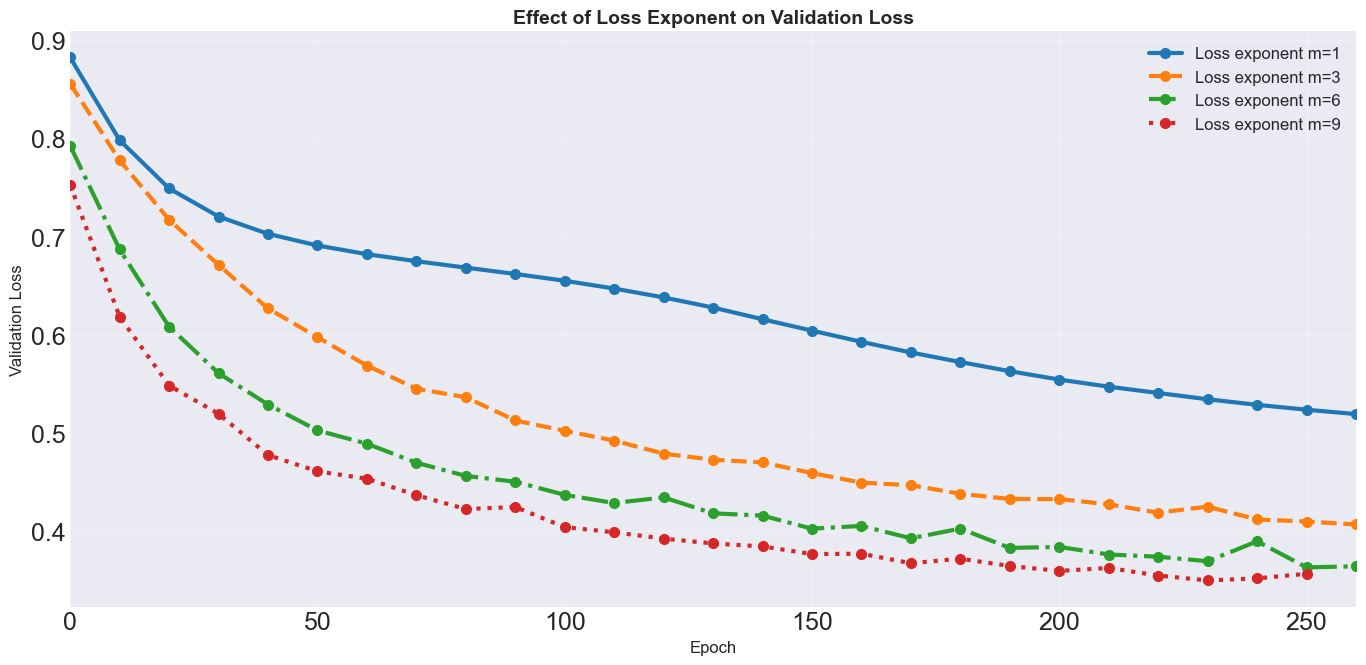

In [ ]:
# Make the plot
plt.figure(figsize=(14, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
line_styles = ['-', '--', '-.', ':']

for i, m in enumerate(loss_exponents):
    epochs_range = np.arange(len(results_m[m]['val_loss'])) * val_every
    val_loss = np.array(results_m[m]['val_loss'])
    
    plt.plot(epochs_range, val_loss,
             marker='o', linewidth=3, markersize=7,
             label=f'Loss exponent m={m}', 
             color=colors[i], linestyle=line_styles[i])

# Set x-axis limit to the shortest training run
min_epochs = min([len(results_m[m]['val_loss']) for m in loss_exponents]) * val_every
plt.xlim(0, min_epochs)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.title('Effect of Loss Exponent on Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Effect of beta
tf.random.set_seed(0)

beta_values = [0.001, 0.005, 0.01, 0.02, 0.05]
results_beta = {}

for beta in beta_values:
    nl = NonlinearDecoder((M,), C, beta=beta)
    nl.output_layer.tanh_beta = beta  # Explicitly set it on the layer
    nl.compile(lr=lr, loss='lp')
    
    train_loss_hist, val_loss_hist, val_acc_hist, epochs_trained = nl.fit(
        train_samps, train_labels, val_samps, val_labels,
        batch_size=mini_batch_sz, max_epochs=max_epochs,
        patience=patience, val_every=val_every, verbose=False)
    
    results_beta[beta] = {
        'val_loss': val_loss_hist,
        'epochs': epochs_trained
    }

print("Beta training completed successfully!")

---------------------------------------------------------------------------
Dense layer output(Output Layer) shape: [1, 3]
---------------------------------------------------------------------------
Training finished after 589 epochs in 8.11 seconds
Learning rate was decayed 0 times.
---------------------------------------------------------------------------
Dense layer output(Output Layer) shape: [1, 3]
---------------------------------------------------------------------------
Training finished after 299 epochs in 3.83 seconds
Learning rate was decayed 0 times.
---------------------------------------------------------------------------
Dense layer output(Output Layer) shape: [1, 3]
---------------------------------------------------------------------------
Training finished after 429 epochs in 5.91 seconds
Learning rate was decayed 0 times.
---------------------------------------------------------------------------
Dense layer output(Output Layer) shape: [1, 3]
----------------------

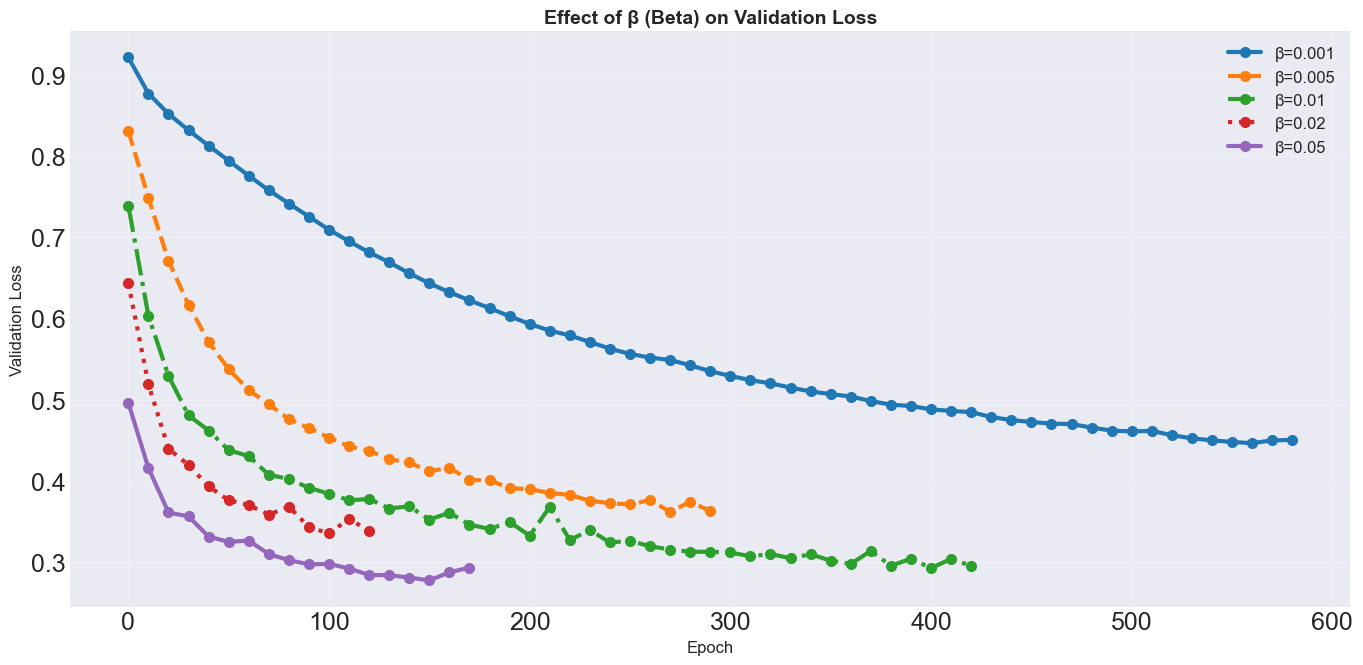

In [15]:
# Make the plot
plt.figure(figsize=(14, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
line_styles = ['-', '--', '-.', ':', '-']

for i, beta in enumerate(beta_values):
    epochs_range = np.arange(len(results_beta[beta]['val_loss'])) * val_every
    val_loss = np.array(results_beta[beta]['val_loss'])
    
    plt.plot(epochs_range, val_loss,  # Plot all data, not masked
             marker='o', linewidth=3, markersize=7,
             label=f'β={beta}', 
             color=colors[i], linestyle=line_styles[i])

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.title('Effect of β (Beta) on Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 8c. Questions

**Question 12:** Explain what you observe about the effect of the loss exponent `m` on the validation loss. What does it indicate about the quality and speed of learning?

**Question 13:** Explain what you observe about the effect of β on the validation loss. What does it indicate about the quality and speed of learning?

**Answer 12:** Higher loss exponents (m=6, m=9) lead to faster convergence and significantly lower final validation loss compared to lower exponents (m=1, m=3). This indicates that larger values of m penalize incorrect predictions more heavily, forcing the network to learn more discriminative features and achieve better classification quality. The speed of learning is also dramatically improved, as evidenced by the steeper initial descent and earlier plateau of the higher-m curves.

**Answer 13:** Higher B values (B=0.02, B=0.05) lead to faster convergence and significantly lower final validation loss compared to lower B values (B=0.001, B=0.005). This indicates that larger B values amplify the nonlinearity of the tanh activation function, creating steeper and more discriminative decision boundaries that allow the network to learn more effective feature representations. The speed of learning is substantially improved, as evidenced by the much steeper initial descent and earlier convergence of the higher-B curves. Conversely, very small B values (B=0.001) result in nearly linear activations that fail to capture the benefits of the nonlinear decoder, leading to slower learning and higher final loss.